In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from cosine_lr_scheduler import CosineLRScheduler
from custom_tokenizer import BytePairEncodingTokenizer
import os, random

tokenizer = BytePairEncodingTokenizer()
tokenizer.load_tokenizer('tokenizer.pkl')
tokenizer.maxlen = 128

def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)
    
reset_random_seeds()

2025-05-16 08:56:02.078683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-16 08:56:02.127412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-16 08:56:02.142345: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-16 08:56:02.177912: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-16 08:56:04.748106: W tensorflow/compiler/tf2

In [2]:
import re
from string import punctuation
from tqdm import tqdm

def preprocess_text(x):
    """
    cleaning tweets -> 
    @user -> USER
    urls -> LINK
    keep only !,.:#? and add space 
    """
    
    x = str(x).replace('&amp;','and').replace('<br />','').replace('&quot;','').lower()
    x = re.sub(r'&#x[0-9A-Fa-f]+;','',x)
    x = re.sub(r'&#\d+;',"'",x)
    x = re.sub(r'[^\x00-\x7F]+', "'",x)
    
    url_pattern = r'http\S+|www\S+'
    x = re.sub(url_pattern, 'LINK', x)
    
    
    
    punct_to_keep = """!,.:#?"-;//%$(){}@^*+<=>\\|'"""
    punct = ''.join([p for p in punctuation if p not in punct_to_keep])
    trans = str.maketrans(punct, ' ' * len(punct))
    x = x.translate(trans)
    x = ''.join(x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])\s*\1+', r'\1', x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', x)
    x = re.sub(r'\s+', ' ', x).strip().replace("'s "," 's ")
    x = x.replace("\\'"," '").replace("'"," ' ")
    
    return re.sub(r'\s+', ' ', x).strip()

In [3]:
import contractions as con
from nltk.tokenize import TreebankWordTokenizer 
import string

tk = TreebankWordTokenizer()

def clean_text(text):
    
    # fix contractions and remove URLs
    text = str(text)
    text = text.lower()
    text = [con.fix(w) for w in text.split()]
    text = ' '.join(text).lower()
    text.replace("'s "," s ")
    
    text = re.sub(r'&#\d+%;',"'",text)
    text = re.sub(r'[^\x00-\x7F]+', "'",text)
    
    url_pattern = r'http\S+|www\S+'
    text = re.sub(url_pattern, '', text)
    

    
    # remove punctuations other than , . : and provide space 
    punct = string.punctuation.replace('.','').replace(',','').replace(':','')
    translation_table = str.maketrans(punct, ' ' * len(punct))
    result_string = text.translate(translation_table)
    text = re.sub(r'\s+', ' ', result_string)
    text = tk.tokenize(text)
    text = ' '.join(text)
    text = re.sub(r'([!"#$%&\'()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', text)
    return text

In [4]:
df = pd.read_csv("/home/bibek/dataset/fr-en-translation.csv",encoding='latin-1')

Y = [preprocess_text(x) for x in tqdm(df['2'])]
X = [preprocess_text(x) for x in tqdm(df['1'])]

100%|█████████████████████████████████| 199337/199337 [00:20<00:00, 9616.21it/s]


In [5]:
X[0],Y[0]

('you thought to this day that there were tyrants ?',
 "vous avez cru jusqu ' ' ce jour qu ' il y avait des tyrans ' ?")

In [6]:
data = [(x,y) for x,y in zip(X,Y)]
np.random.shuffle(data)
X = [x[0] for x in data]
Y = [x[1] for x in data]

In [7]:
# initiate new tokenizer class and train it on french vocab

_tokenizer = BytePairEncodingTokenizer(15000,500000)
_tokenizer(Y)

_tokenizer.maxlen = 128

_tokenizer.train(iterations=5,
                 min_pair_freq=2,
                 special_tokens=['LINK'],strategy='coverage')

In [8]:
from sklearn.model_selection import train_test_split

_tokenizer.maxlen = 128
X = [tokenizer.tokenize(x) for x in tqdm(X)]

tokenizer.maxlen = 128
Y = [_tokenizer.tokenize(x) for x in tqdm(Y)]

_tokenizer.maxlen = 128
Y = np.array([_tokenizer.add_padding(x) for x in Y],np.int16)

tokenizer.maxlen = 128
X = np.array([tokenizer.add_padding(x) for x in X],np.int16)

100%|██████████████████████████████████| 199337/199337 [04:35<00:00, 724.25it/s]


In [9]:
# split train test and val as 70% 20% and 10%

xtrain,xval,ytrain,yval = train_test_split(X,Y,train_size=0.7,random_state=0)
xtest,xval,ytest,yval = train_test_split(xval,yval,train_size=0.66,random_state=0)

In [10]:
for _ in range(5):
    
    i = np.random.randint(0,len(xtrain)-1)

    print(' '.join([tokenizer.i2w[t] for t in xtrain[i] if t > 0]))
    print()
    print(' '.join([_tokenizer.i2w[t] for t in ytrain[i] if t > 0]))
    print("-------------------------------------------------------------------------")

<cls> he ev ok es the c her no by l disaster in le par ad is exist e ( 2001 ) , chronic le of a village in ukraine . <sep>

<cls> il ' voque la catastrophe de t cher no by l dans le paradis existe ( 2001 ) , chronique d ' un village d ' ukraine . <sep>
-------------------------------------------------------------------------
<cls> t ref o us se considers johnson ' s legacy to be " the maintenance of white supremacy . <sep>

<cls> tre fous se consid ' re que l ' h ' ritage de johnson est ' la maintenance de la supr ' matie blanche . <sep>
-------------------------------------------------------------------------
<cls> template : demo g ra fi a / c iv it ella ca san o va the country still has its own customs and traditions , which usually occur every year . <sep>

<cls> mod ' le : dem og raf ia / ci vite ll a casa nova le pays a toujours ses propres coutumes et traditions , qui se produisent habituellement chaque ann ' e . <sep>
------------------------------------------------------------

In [11]:
xtrain.shape,xtest.shape,xval.shape

((139535, 128), (39469, 128), (20333, 128))

In [12]:
# define training params

MAXLEN = 128
BATCH = 32
EPOCHS = 4

PEAK_LR = 2e-4
END_LR = 1e-7
INIT_LR = 0
WARMUP_RATE = 0.05

reset_random_seeds()

# load and build model with pretrained weights

i1 = tf.keras.layers.Input((128,),BATCH,tf.int16)
i2 = tf.keras.layers.Input((128-1,),BATCH,tf.int16)

model = tf.keras.models.load_model('robust_net.keras')
model([i1,i2])
model.load_weights('robust_net.weights.h5')

model.summary()


I0000 00:00:1747366613.598171    9520 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747366613.627461    9520 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747366613.627665    9520 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747366614.043357    9520 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "robust_net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ factorized_embedding_layer      │ ?                      │     1,957,760 │
│ (FactorizedEmbeddingLayer)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block (EncoderBlock)    │ ?                      │     1,054,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block (DecoderBlock)    │ ?                      │     1,316,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 127, 15037)       │     3,864,509 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,192,829 (31.25 MB)

 Trainable params: 8,192,829 (31.25 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# since this model originally has a shared embedding matrix followed by a factorization layer
# we extract some layers and construct a subclass model for nmt task

In [14]:
# extract layers
# we shall add a new embedding matrix for french vocab and reintialize a new softmax output head
# as the current one is for english vocab embedding matrix 

fact_layer = model.layers[0].fact_layer
x_emb = model.layers[0].emb_layer
encoder = model.layers[1]
decoder = model.layers[2]
pos_encodings = model.layers[0].pos_encodings

In [15]:
from tensorflow.keras.layers import Embedding, Dense

class NMTModel(tf.keras.Model):
    
    def __init__(self,vocab_size,maxlen = 128):
        super().__init__()
        self.vocab_size = vocab_size
        self.maxlen = maxlen
        
    def build(self,input_shape):
        super().build(input_shape)
        self.y_emb = Embedding(self.vocab_size,128)
        self.x_emb = x_emb
        self.fact_layer = fact_layer
        self.encoder = encoder
        self.decoder = decoder
        self.pos_encodings = pos_encodings
        self.output_head = Dense(self.vocab_size,activation='softmax')
        
    def call(self,inputs):
        
        x,y = inputs
        
        x_mask = x == 0
        y_mask = y == 0
        
        x = self.fact_layer(self.x_emb(x)) + self.pos_encodings[:x.shape[1],:]
        y = self.fact_layer(self.y_emb(y)) + self.pos_encodings[:y.shape[1],:]
        
        en_out = self.encoder([x,x_mask])
        dec_out = self.decoder([y,en_out,y_mask,x_mask])
        
        return self.output_head(dec_out)
    
model = NMTModel(len(_tokenizer.i2w))
model.build([i1.shape,i2.shape])
model([i1,i2])
model.summary()
        

Model: "nmt_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (32, 127, 128)         │     1,924,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (32, 128, 128)         │     1,924,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 128, 256)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block (EncoderBlock)    │ ?                      │     1,054,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block (DecoderBlock)    │ ?                      │     1,316,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (32, 127, 15038)       │     3,864,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,117,950 (38.60 MB)

 Trainable params: 10,117,950 (38.60 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
opt = tf.keras.optimizers.AdamW(weight_decay=0.01)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

train = tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
train = train.batch(batch_size=BATCH, drop_remainder=True).shuffle(buffer_size=1000)

val = tf.data.Dataset.from_tensor_slices((xval,yval))
val = val.batch(batch_size=BATCH * 2).shuffle(buffer_size=1000)

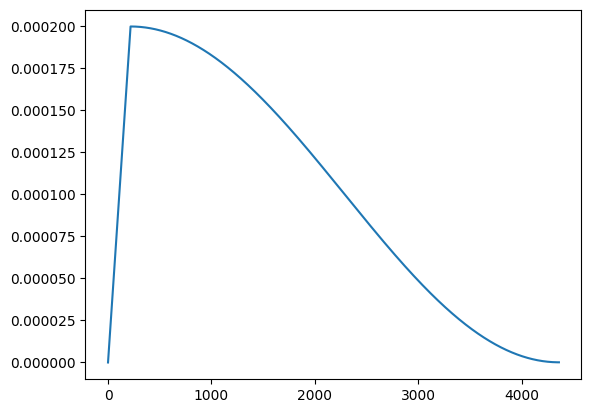

In [17]:
import matplotlib.pyplot as plt
from cosine_lr_scheduler import CosineLRScheduler

steps = xtrain.shape[0] // BATCH

lr_scheduler = CosineLRScheduler(steps,peak_lr=PEAK_LR,min_lr=END_LR,
                                 init_lr=INIT_LR,warmup_rate=WARMUP_RATE)

plt.plot([lr_scheduler(i+1) for i in range(steps)])

In [18]:
@tf.function
def train_step(x,y):
    tar_in = y[:,:-1]
    tar_out = y[:,1:]
    with tf.GradientTape() as tape:
        pred = model([x,tar_in],training=True)
        loss = loss_fn(tar_out,pred,sample_weight=tar_out>0)
    weights = model.trainable_weights
    grads = tape.gradient(loss,weights)
    opt.apply_gradients(zip(grads,weights))
    return loss

@tf.function
def test_step(x,y):
    tar_in = y[:,:-1]
    tar_out = y[:,1:]
    pred = model([x,tar_in],training=False)
    loss = loss_fn(tar_out,pred,sample_weight=tar_out>0)
    return loss


In [19]:
def sample(x,y,return_out=False):

    en_in = x[np.newaxis,:]
    dec_in = np.array([[1]],np.int16)
    out = []

    for _ in range(MAXLEN):

        p = model([en_in,dec_in])
        tok = np.argmax(p[0,-1,:],axis=-1)
        out.append(tok)

        if tok == tokenizer.w2i['<sep>'] or len(out) == MAXLEN:
            break

        tok = np.array([tok],np.int16)
        dec_in = np.concatenate([dec_in[0],tok],axis=0)[np.newaxis,:]

    print('input : ',' '.join([tokenizer.i2w[t] for t in x if t>0]).replace('|','\n'))
    print()
    print('actual : ', ' '.join([_tokenizer.i2w[t] for t in y if t > 0]))
    print()
    print('predicted :',' '.join([_tokenizer.i2w[t] for t in out]))
    print("---------------------------------------------------------------------")
    
    if return_out:
        return out

In [20]:
out = sample(xtest[-2],ytest[-2],True)

input :  <cls> however , interest in other applications quickly developed , and within five years the soviet program was actively exploring six or seven applications involving participation by some ten government departments . <sep>

actual :  <cls> cependant , d ' autres applications ' veill ' rent rapidement l ' int ' r ' t des sovi ' tiques , et au bout de cinq ans , le programme explor ait activement six ou sept applications , impliquant la participation de pr ' s de dix organes gouvernementaux . <sep>

predicted : cifiquement gonna gonna gonna gonna engager engager engager gonna engager engager engager souhaitable gonna gonna gonna engager engager engager engager souhaitable gonna gonna gonna gonna gonna engager engager engager immobili immobili immobili jordanie jordanie engager cheveux gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonna gonn

In [21]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.bleu_score import corpus_bleu
from nltk import word_tokenize

def compute_bleu(preds, refs):
    """
    preds: list of predicted strings
    refs: list of reference strings (same length)
    Returns: average BLEU-1/2/3/4 and ROUGE-L
    """
    assert len(preds) == len(refs), "Number of predictions and references must match."

    smooth_fn = SmoothingFunction().method2

    bleu_scores = {1: [], 2: [], 3: [], 4: []}

    for pred, ref in zip(preds, refs):
        pred_tokens = word_tokenize(pred)
        ref_tokens = word_tokenize(ref)

        # BLEU scores
        for n in range(1, 5):
            weights = tuple((1.0 / n if i < n else 0.0) for i in range(4))
            score = sentence_bleu([ref_tokens], pred_tokens, weights=weights, smoothing_function=smooth_fn)
            bleu_scores[n].append(score)

    # Average scores
    avg_bleu = {f"BLEU-{n}": sum(scores)/len(scores) for n, scores in bleu_scores.items()}

    return avg_bleu

def compute_rouge(preds,ref):
    
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    final_scores = {'rouge1':0, 'rouge2':0, 'rougeL':0}
    
    
    for pred in preds:
        scores = scorer.score(pred, ref)
        
        for k in scores:
            final_scores[k] += np.mean(scores[k])
            
    for k in final_scores:
        final_scores[k] = final_scores[k] / len(preds)
            
    return final_scores

epoch : 1/4


100%|█████████████████████████████████████████| 318/318 [00:26<00:00, 11.92it/s]


train loss: 0.7819
val loss: 0.5604
weights saved!

input :  <cls> however , interest in other applications quickly developed , and within five years the soviet program was actively exploring six or seven applications involving participation by some ten government departments . <sep>

actual :  <cls> cependant , d ' autres applications ' veill ' rent rapidement l ' int ' r ' t des sovi ' tiques , et au bout de cinq ans , le programme explor ait activement six ou sept applications , impliquant la participation de pr ' s de dix organes gouvernementaux . <sep>

predicted : cependant , l ' int ' r ' t ' d ' autres applications d ' autres applications , et au cours de cinq ans , l ' ' tat sovi ' tique a ' t ' activement ' plusieurs applications de l ' ann ' e , entre les dix - uns des dix - uns des dix - uns des dix - uns . <sep>
---------------------------------------------------------------------
----------------------------------------------------------------------


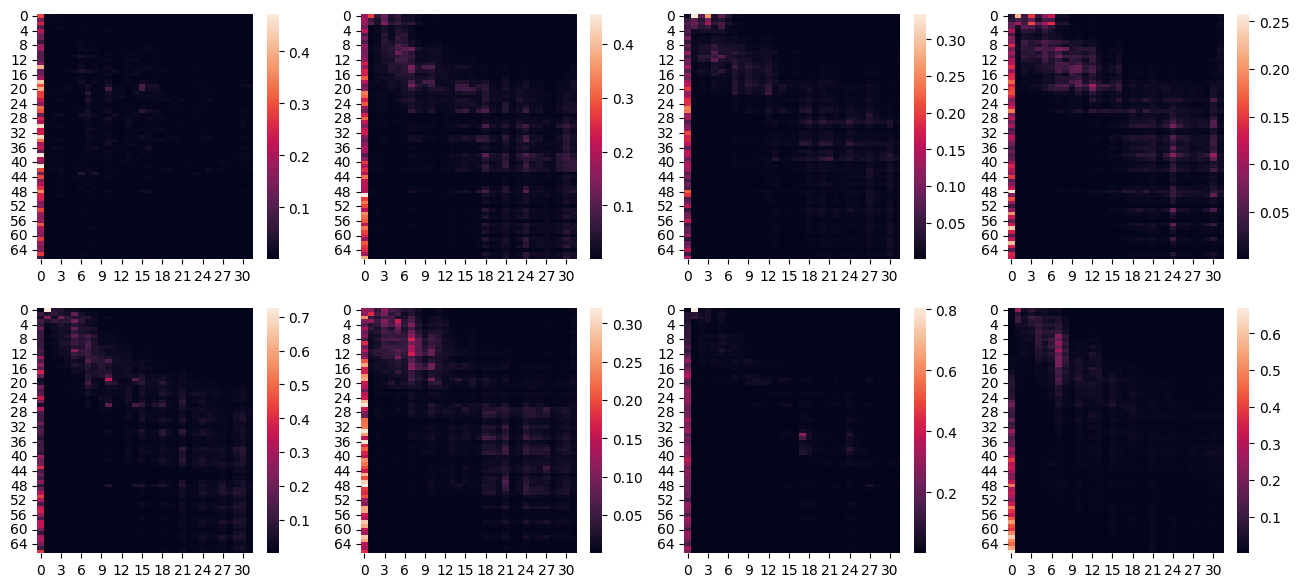

epoch : 2/4


100%|█████████████████████████████████████████| 318/318 [00:26<00:00, 12.21it/s]


train loss: 0.4609
val loss: 0.4218
weights saved!

input :  <cls> however , interest in other applications quickly developed , and within five years the soviet program was actively exploring six or seven applications involving participation by some ten government departments . <sep>

actual :  <cls> cependant , d ' autres applications ' veill ' rent rapidement l ' int ' r ' t des sovi ' tiques , et au bout de cinq ans , le programme explor ait activement six ou sept applications , impliquant la participation de pr ' s de dix organes gouvernementaux . <sep>

predicted : cependant , l ' int ' r ' t dans d ' autres applications d ' velopp ' es , et au sein de cinq ans , le programme sovi ' tique ' tait activement ' explorer six ou sept applications impliquant la participation de dix - uns des dix - uns des dix - uns des dix - uns des dix - uns des dix - uns . <sep>
---------------------------------------------------------------------
------------------------------------------------------

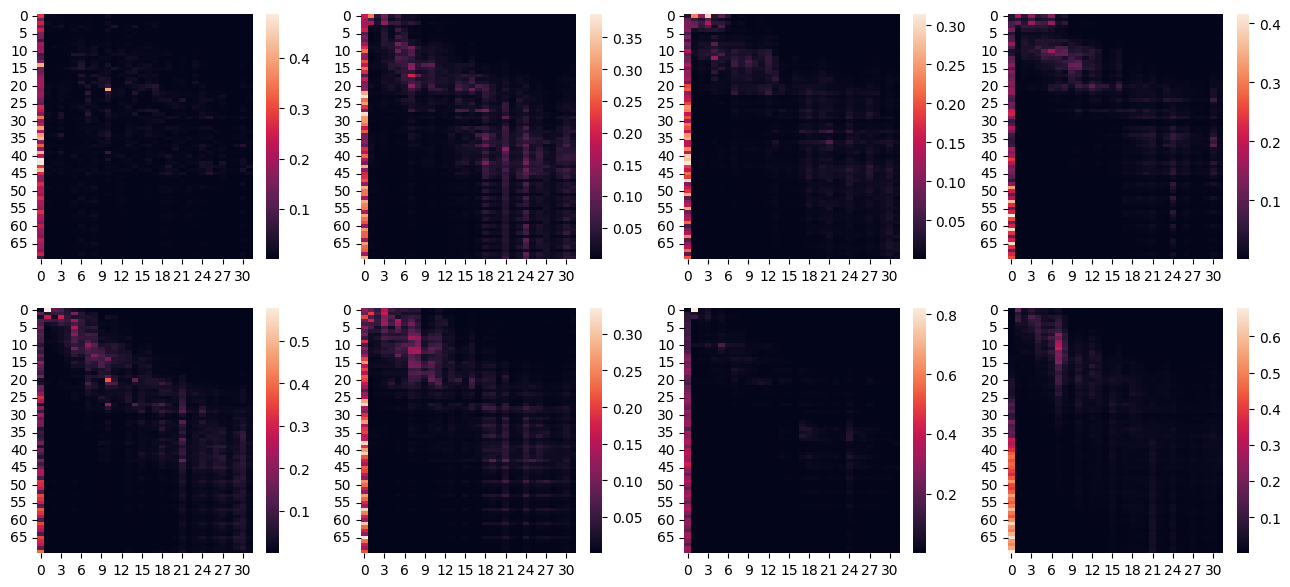

epoch : 3/4


100%|█████████████████████████████████████████| 318/318 [00:26<00:00, 12.16it/s]


train loss: 0.3779
val loss: 0.3751
weights saved!

input :  <cls> however , interest in other applications quickly developed , and within five years the soviet program was actively exploring six or seven applications involving participation by some ten government departments . <sep>

actual :  <cls> cependant , d ' autres applications ' veill ' rent rapidement l ' int ' r ' t des sovi ' tiques , et au bout de cinq ans , le programme explor ait activement six ou sept applications , impliquant la participation de pr ' s de dix organes gouvernementaux . <sep>

predicted : cependant , l ' int ' r ' t dans d ' autres applications d ' velopp ' es , et au sein de cinq ans , le programme sovi ' tique ' tait activement explor ' e six ou sept applications impliquant la participation de dix - sept d ' partements . <sep>
---------------------------------------------------------------------
----------------------------------------------------------------------


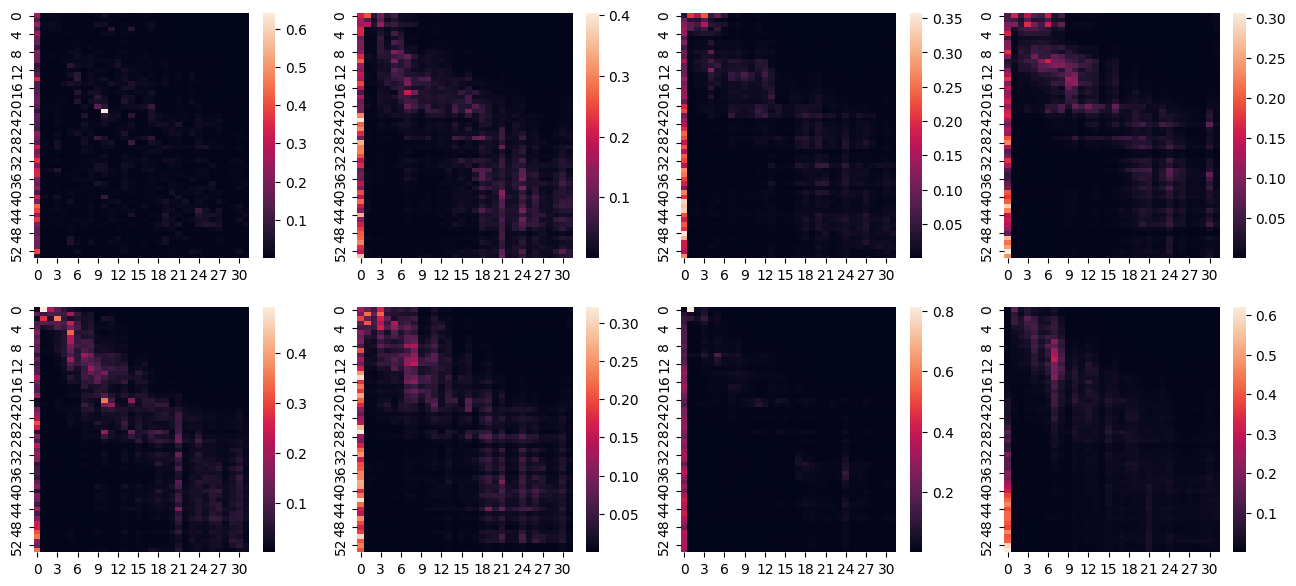

epoch : 4/4


100%|█████████████████████████████████████████| 318/318 [00:26<00:00, 12.14it/s]


train loss: 0.3343
val loss: 0.3507
weights saved!

input :  <cls> however , interest in other applications quickly developed , and within five years the soviet program was actively exploring six or seven applications involving participation by some ten government departments . <sep>

actual :  <cls> cependant , d ' autres applications ' veill ' rent rapidement l ' int ' r ' t des sovi ' tiques , et au bout de cinq ans , le programme explor ait activement six ou sept applications , impliquant la participation de pr ' s de dix organes gouvernementaux . <sep>

predicted : cependant , l ' int ' r ' t dans d ' autres applications d ' velopp ' es , et au sein de cinq ans , le programme sovi ' tique ' tait activement explor ' e six ou sept applications impliquant la participation de dix - sept d ' partements . <sep>
---------------------------------------------------------------------
----------------------------------------------------------------------


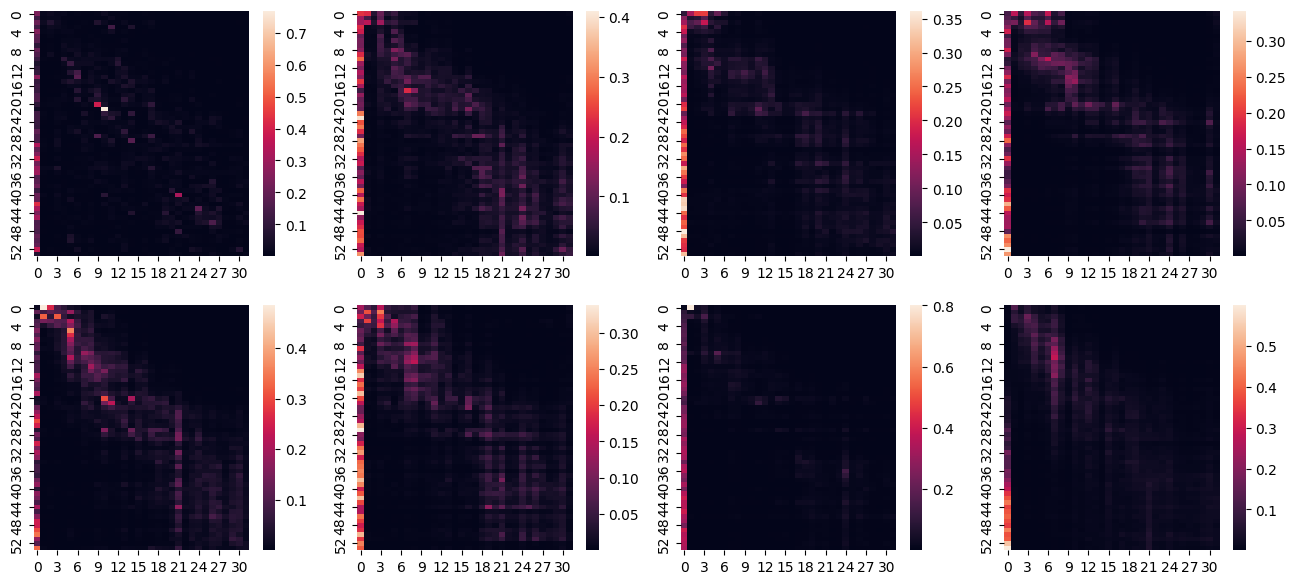

In [22]:
import seaborn as sb

losses = {'train':[],'valid':[]}

for e in range(EPOCHS):

    e += 1
    print(f'epoch : {e}/{EPOCHS}')

    loss = 0
    
    # run train step 
    for i,(x,y) in enumerate(tqdm(train)):
        # get lr for current step and assign
        lr = lr_scheduler(i+1) 
        opt.learning_rate.assign(lr)
        loss += train_step(x,y)
        
    # save training loss
    train_loss = round(loss.numpy()/(i+ 1),4)
    losses['train'].append(train_loss)
    
    
    loss = 0
    
    # run test step
    for i,(x,y) in enumerate(tqdm(val)):
        loss += test_step(x,y)

    loss = round(loss.numpy() / (i + 1),4)

    print(f'train loss: {train_loss}\nval loss: {loss}')

    if e == 1:
        model.save_weights('vanilla_weights-1.weights.h5')
        print('weights saved!')

    elif e > 1 and min(losses['valid']) > loss:
        model.save_weights('vanilla_weights-1.weights.h5')
        print('weights saved!')

    losses['valid'].append(loss)
    print()
    sample(xtest[-2],ytest[-2])
    print('----------------------------------------------------------------------')

    attn_scores = model.decoder.decoder_layers[0].mhca.attention_scores
    max_x = attn_scores[0,0,0,:].numpy()
    max_x = np.where(max_x>0)[0][-1]

    attn_scores = attn_scores[:,:,:,:max_x]

    maxlen = attn_scores.shape[2]

    attn_scores = attn_scores.numpy()[0]

    _,ax = plt.subplots(2,4,figsize=(16,7))

    for i in range(2):
        for j in range(4):
            sb.heatmap(np.reshape(attn_scores,(2,4,maxlen,max_x))[i][j],ax=ax[i][j])

    plt.show()           
       

In [23]:
from beam_search import BeamSearchDecoder
beam_search = BeamSearchDecoder(model,_tokenizer,_tokenizer)

In [24]:
model.load_weights("vanilla_weights-1.weights.h5")

In [25]:
bleu = {'b1':0,'b2':0,'b3':0,'b4':0}
rouge = {'r1':0,'r2':0,'rL':0}

In [26]:
idx = np.arange(30)

for i in idx:
    
    i += 1
    
    x = xtest[-i]
    y = ytest[-i]
    
    actual = ' '.join([_tokenizer.i2w[t] for t in y if t > 0])
    
    print("INPUT :",' '.join([tokenizer.i2w[t] for t in x if t > 0]).replace(' | ','\n').replace('<cls>','<cls>\n'))
    print()
    print("ACTUAL :",actual)
    print()
    
    beam1 = beam_search.summarize(x,ymax=MAXLEN,k=1,alpha=0.7)[0][0]
    beam3 = beam_search.summarize(x,ymax=MAXLEN,k=3,alpha=0.7)[0][0]
    
    
    print("1 BEAM :",beam1)
    print("3 BEAM :",beam3)
    
#     for 
    
    scores = compute_bleu([beam1,beam3],[actual,actual])
    
    for a,b in zip(bleu,scores):
        bleu[a] += scores[b]
    
    print()
    print(scores)
    
        
    scores = compute_rouge([beam1,beam3],actual)
    
    for a,b in zip(rouge,scores):
        rouge[a] += scores[b]
    
    print(scores)
    print("--------------------------------------------------------------------------------------")


INPUT : <cls>
 the school closed in 18 72 after the me i ji restoration and the introduction of the new school system . <sep>

ACTUAL : <cls> l ' ' cole ferme en 1872 apr ' s la restauration de meiji et l ' introduction du nouveau syst ' me scolaire . <sep>

1 BEAM : <cls> l ' ' cole ferme en 1872 apr ' s la restauration meiji et l ' introduction du syst ' me scolaire . <sep>
3 BEAM : <cls> l ' ' cole ferme en 1872 apr ' s la restauration meiji et l ' introduction du syst ' me scolaire . <sep>

{'BLEU-1': 0.9333588643117228, 'BLEU-2': 0.9005991641375098, 'BLEU-3': 0.8657416575477405, 'BLEU-4': 0.8284518712245094}
{'rouge1': 0.9515873015873016, 'rouge2': 0.8436647173489279, 'rougeL': 0.9515873015873016}
--------------------------------------------------------------------------------------
INPUT : <cls>
 however , interest in other applications quickly developed , and within five years the soviet program was actively exploring six or seven applications involving participation by some ten

1 BEAM : <cls> khan voulait m ' me ka ka ka ma ' jouer le juge et di ip ka le fils . <sep>
3 BEAM : <cls> khan voulait m ' me ka ka ka ma ' jouer le juge et di ip ka le fils . <sep>

{'BLEU-1': 0.6153846153846154, 'BLEU-2': 0.5547001962252291, 'BLEU-3': 0.4974226346394325, 'BLEU-4': 0.43527713779415106}
{'rouge1': 0.5789473684210527, 'rouge2': 0.3888888888888889, 'rougeL': 0.5789473684210527}
--------------------------------------------------------------------------------------
INPUT : <cls>
 50 cent lasted nearly 20 minutes before finally throwing his microphone into the crowd in anger . <sep>

ACTUAL : <cls> 50 cent r ' sist a presque 20 minutes avant de finalement jeter de rage son micro dans la foule . <sep>

1 BEAM : <cls> 50 cent ont dur ' pr ' s de 20 minutes avant d ' avoir jet ' son micro phone dans la foule de la foule . <sep>
3 BEAM : <cls> 50 cent ont dur ' pr ' s de 20 minutes avant d ' avoir jet ' son micro phone dans la foule en col ' re . <sep>

{'BLEU-1': 0.58244206773

1 BEAM : <cls> menzies , dans l ' hiver europ ' enne , a chut ' sur les routes d ' i ques , cass ' rent un bon c ' t ' et manqu ' 24 jours . <sep>
3 BEAM : <cls> menzies , dans l ' hiver europ ' enne , ' tait tomb ' e sur les routes d ' i ques , cass ' rent un c ' t ' de 24 jours . <sep>

{'BLEU-1': 0.6867015098722415, 'BLEU-2': 0.5457717054263339, 'BLEU-3': 0.46872319460116174, 'BLEU-4': 0.42058049037051415}
{'rouge1': 0.5741930618401208, 'rouge2': 0.2887301587301587, 'rougeL': 0.5545801910507793}
--------------------------------------------------------------------------------------
INPUT : <cls>
 va z i r o v wrote at least two books that were published while he was in turkey : ( 1 ) " a survey of a z er ba i jan i literature " ( 19 21 ) , and ( 2 ) " the history , geography and economy of a z er ba i jan " ( 19 21 ) . <sep>

ACTUAL : <cls> v az ir o v a ' crit au moins deux livres qui ont ' t ' publi ' s tandis qu ' il ' tait en turquie ' : ( 1 ) " une enqu ' te sur la litt ' rature

1 BEAM : <cls> diff ' rents algorithmes utilisent diff ' rentes m ' thodes pour d ' terminer si une barri ' re est s ' curis ' e . <sep>
3 BEAM : <cls> diff ' rents algorithmes utilisent des m ' thodes diff ' rentes pour d ' terminer si un saut est s ' curis ' . <sep>

{'BLEU-1': 0.8455522971652003, 'BLEU-2': 0.7965970302987482, 'BLEU-3': 0.7420140688874011, 'BLEU-4': 0.6817805970876574}
{'rouge1': 0.8624092281987019, 'rouge2': 0.6942613666297877, 'rougeL': 0.8111046847888952}
--------------------------------------------------------------------------------------


In [27]:
{k:v/len(idx) for k,v in bleu.items()}

{'b1': 0.7281819174417369,
 'b2': 0.6481455817486927,
 'b3': 0.5787918858840803,
 'b4': 0.5137951676092319}

In [28]:
{k:v/len(idx) for k,v in rouge.items()}

{'r1': 0.7055244385431738, 'r2': 0.5061117593584895, 'rL': 0.6798596856988266}